In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import csv
import time

import sys
sys.path.insert(0, "../../utils/")
import utils as ut

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import MeanSquaredError
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras import backend as K

## Input options

In [3]:
features_names   = ['m1', 'm2', 's1x', 's1y', 's1z', 's2x', 's2y', 's2z', 'theta', 'q', 'Mc'];
regr_data_dir    = '../../datasets/NewRealistic/'
write_output     = False
out_data_dir     = '../../datasets/NN_tf_results/'
versions         = ['0', '1'] # can be a subset of ['0', '1', '2']
clabels          = ['0', '1'] # can be a subset of ['0', '1'] 

# training options
remove_some_mass = False
epochs           = 250
validation_split = 0.1
batch_size       = 64
verbose_training = True
hlayers_sizes    = [100, 100];
learning_rate    = 0.0001
scaler_type      = 'mixed'  # standard, minmax, mixed
activation       = 'relu'
out_activation   = 'linear_cut_mod' # sigmoid, linear, linear_cut, linear_cut_T3, linear_cut_lb, linear_cut_mod

## Check on input and dictionary-initialization

In [4]:
# define dictionary for each version considered
Nv       = len(versions)
Nc       = len(clabels)
Nsets    = Nv*Nc

if Nv*Nc!=Nsets:
    print('+++ Wrong input! +++')

datasets = {}
keys     = []
for i in range(0,Nv):
    version = versions[i]
    for j in range(0,Nc):
        clabel = clabels[j]
        key = 'v'+version+'c'+clabel
        keys.append(key)
        datasets[key]         = lambda:0
        datasets[key].clabel  = clabel
        datasets[key].version = version

In [5]:
# define all the ouput activation functions
def output_activation_sigmoid(x):
    return K.sigmoid(x)*2-1

def output_activation_linear(x):
    return x

def output_activation_linear_cut(x):
    signs = K.switch(x>0, 1+x*0, -1+x*0) # x*0 in order to broadcast to correct dimension
    return K.switch(abs(x)<1, x, signs)

def output_activation_linear_cut_T3(x):
    return 2/(K.exp(-(2*x+2/3*x*x*x))+1)-1

def output_activation_linear_cut_lb(x):
    return K.switch(x>-1, x, -1+x*0)

# define model using Functional API
def buildModelUsingFunctionalAPI(hlayers_sizes, batch_size, Nfeatures, out_activation='linear'):
    model_input = tf.keras.Input(shape=(Nfeatures))
    x = Dense(hlayers_sizes[0], kernel_initializer='normal', activation=activation)(model_input)
    for i in range(1, len(hlayers_sizes)):
        x = Dense(hlayers_sizes[i], kernel_initializer='normal', activation=activation)(x)
    
    if out_activation=="sigmoid":
        out = Dense(Nfeatures, kernel_initializer='normal',\
                    activation=output_activation_sigmoid)(x)
    
    elif out_activation=="linear":
        out = Dense(Nfeatures, kernel_initializer='normal',\
                    activation=output_activation_linear)(x)
        
    elif out_activation=="linear_cut":
        out = Dense(Nfeatures, kernel_initializer='normal',\
                    activation=output_activation_linear_cut)(x)    
    
    elif out_activation=="linear_cut_T3":
        out = Dense(Nfeatures, kernel_initializer='normal',\
                    activation=output_activation_linear_cut_T3)(x)
    
    elif out_activation=="linear_cut_lb":
        out = Dense(Nfeatures, kernel_initializer='normal',\
                    activation=output_activation_linear_cut_lb)(x)
    
    elif out_activation=="linear_cut_mod":
        if Nfeatures==11:
            neuronsA = 2 # m1, m2
            neuronsB = 7 # s1,s2,theta
            neuronsC = 2 # q, Mc
        elif Nfeatures==9:
            neuronsA = 1 # m1
            neuronsB = 7 # s1,s2,theta
            neuronsC = 1 # Mc
        else:
            print("'linear_cut_mod' is hardcoded for Nfeatures=9,11!")
            sys.exit()
        branchA = Dense(neuronsA, kernel_initializer='normal', activation=output_activation_linear_cut_lb)(x)
        branchB = Dense(neuronsB, kernel_initializer='normal', activation=output_activation_linear_cut)(x)
        branchC = Dense(neuronsC, kernel_initializer='normal', activation=output_activation_linear_cut_lb)(x)
        out = tf.keras.layers.concatenate([branchA, branchB, branchC])

    return tf.keras.Model(model_input, out)

mse = MeanSquaredError()

## Loop on versions

********************************************************************************
Key: v0c0
********************************************************************************
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 11)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 100)          1200        ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 100)          10100       ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)     

Epoch 69/250
282/282 [==============================] - 1s 2ms/step - loss: 0.0123 - mean_squared_error: 0.0123 - accuracy: 0.8791 - val_loss: 0.0155 - val_mean_squared_error: 0.0156 - val_accuracy: 0.8925
Epoch 70/250
282/282 [==============================] - 1s 2ms/step - loss: 0.0122 - mean_squared_error: 0.0122 - accuracy: 0.8800 - val_loss: 0.0150 - val_mean_squared_error: 0.0150 - val_accuracy: 0.8930
Epoch 71/250
282/282 [==============================] - 1s 2ms/step - loss: 0.0122 - mean_squared_error: 0.0122 - accuracy: 0.8811 - val_loss: 0.0150 - val_mean_squared_error: 0.0150 - val_accuracy: 0.8900
Epoch 72/250
282/282 [==============================] - 1s 2ms/step - loss: 0.0121 - mean_squared_error: 0.0121 - accuracy: 0.8783 - val_loss: 0.0147 - val_mean_squared_error: 0.0148 - val_accuracy: 0.8945
Epoch 73/250
282/282 [==============================] - 1s 2ms/step - loss: 0.0120 - mean_squared_error: 0.0120 - accuracy: 0.8808 - val_loss: 0.0153 - val_mean_squared_error: 

Epoch 109/250
282/282 [==============================] - 1s 2ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - accuracy: 0.8865 - val_loss: 0.0133 - val_mean_squared_error: 0.0134 - val_accuracy: 0.8995
Epoch 110/250
282/282 [==============================] - 1s 2ms/step - loss: 0.0103 - mean_squared_error: 0.0103 - accuracy: 0.8871 - val_loss: 0.0132 - val_mean_squared_error: 0.0132 - val_accuracy: 0.8985
Epoch 111/250
282/282 [==============================] - 1s 2ms/step - loss: 0.0103 - mean_squared_error: 0.0103 - accuracy: 0.8864 - val_loss: 0.0135 - val_mean_squared_error: 0.0135 - val_accuracy: 0.8965
Epoch 112/250
282/282 [==============================] - 1s 2ms/step - loss: 0.0103 - mean_squared_error: 0.0103 - accuracy: 0.8875 - val_loss: 0.0135 - val_mean_squared_error: 0.0135 - val_accuracy: 0.8980
Epoch 113/250
282/282 [==============================] - 1s 2ms/step - loss: 0.0102 - mean_squared_error: 0.0102 - accuracy: 0.8870 - val_loss: 0.0129 - val_mean_squared_er

Epoch 188/250
282/282 [==============================] - 1s 2ms/step - loss: 0.0084 - mean_squared_error: 0.0084 - accuracy: 0.8959 - val_loss: 0.0111 - val_mean_squared_error: 0.0111 - val_accuracy: 0.9040
Epoch 189/250
282/282 [==============================] - 1s 2ms/step - loss: 0.0084 - mean_squared_error: 0.0084 - accuracy: 0.8977 - val_loss: 0.0116 - val_mean_squared_error: 0.0116 - val_accuracy: 0.9025
Epoch 190/250
282/282 [==============================] - 1s 2ms/step - loss: 0.0083 - mean_squared_error: 0.0083 - accuracy: 0.8971 - val_loss: 0.0113 - val_mean_squared_error: 0.0113 - val_accuracy: 0.9060
Epoch 191/250
282/282 [==============================] - 1s 2ms/step - loss: 0.0083 - mean_squared_error: 0.0083 - accuracy: 0.8961 - val_loss: 0.0111 - val_mean_squared_error: 0.0111 - val_accuracy: 0.9035
Epoch 192/250
282/282 [==============================] - 1s 2ms/step - loss: 0.0083 - mean_squared_error: 0.0083 - accuracy: 0.8986 - val_loss: 0.0109 - val_mean_squared_er

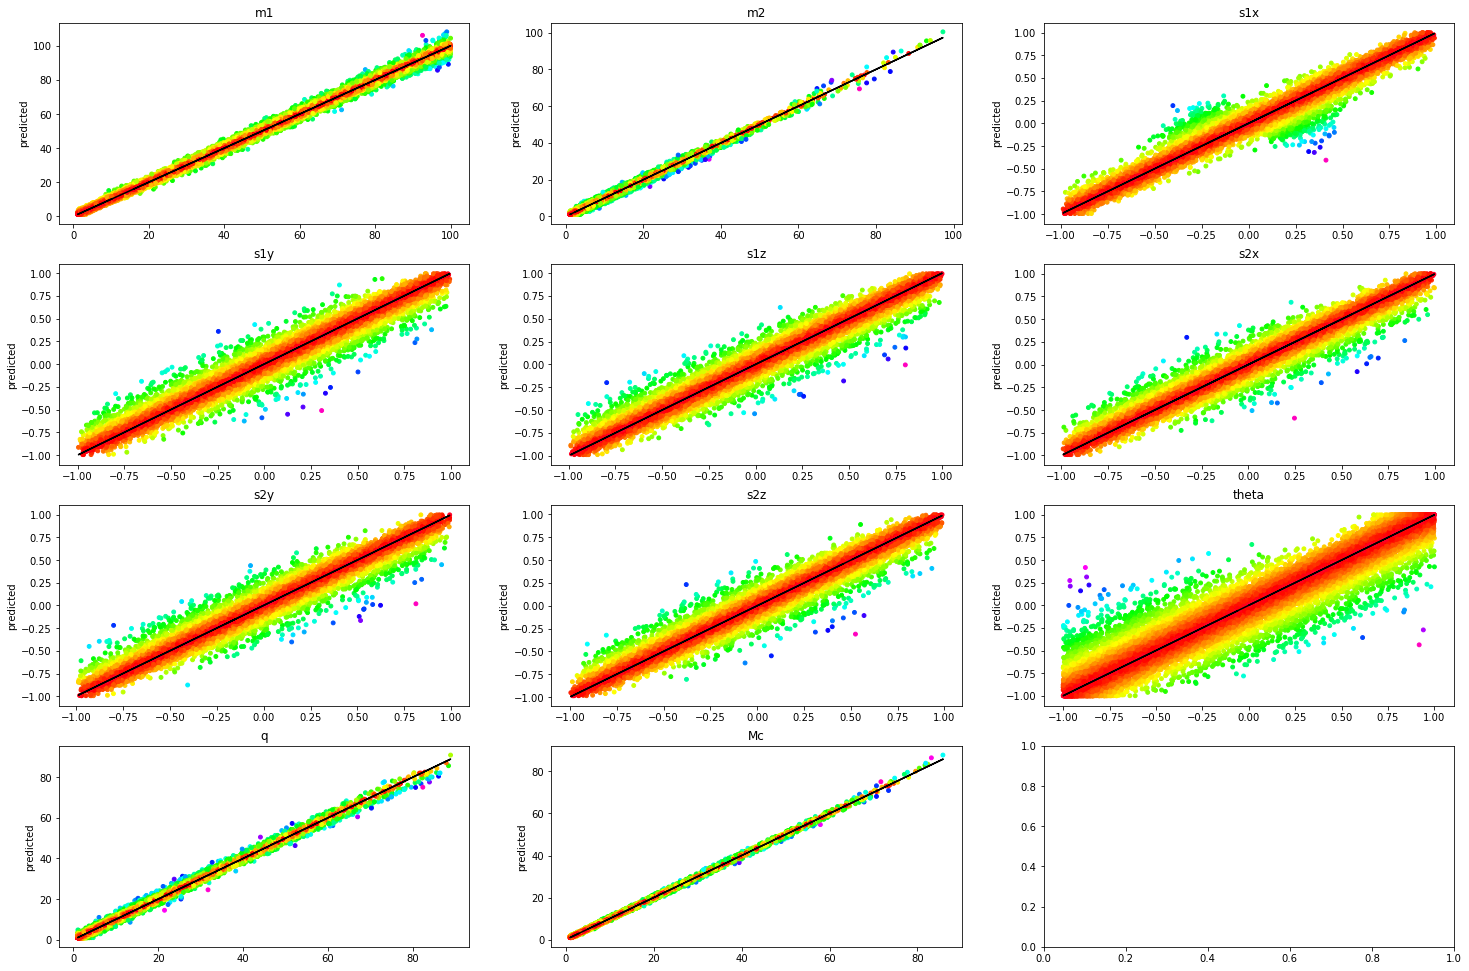

********************************************************************************
Key: v0c1
********************************************************************************
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 11)]         0           []                               
                                                                                                  
 dense_5 (Dense)                (None, 100)          1200        ['input_2[0][0]']                
                                                                                                  
 dense_6 (Dense)                (None, 100)          10100       ['dense_5[0][0]']                
                                                                                                  
 dense_7 (Dense)   

Epoch 69/250
282/282 [==============================] - 1s 2ms/step - loss: 0.0124 - mean_squared_error: 0.0124 - accuracy: 0.8804 - val_loss: 0.0130 - val_mean_squared_error: 0.0129 - val_accuracy: 0.8770
Epoch 70/250
282/282 [==============================] - 1s 2ms/step - loss: 0.0124 - mean_squared_error: 0.0124 - accuracy: 0.8810 - val_loss: 0.0129 - val_mean_squared_error: 0.0128 - val_accuracy: 0.8780
Epoch 71/250
282/282 [==============================] - 1s 2ms/step - loss: 0.0123 - mean_squared_error: 0.0123 - accuracy: 0.8804 - val_loss: 0.0127 - val_mean_squared_error: 0.0126 - val_accuracy: 0.8800
Epoch 72/250
282/282 [==============================] - 1s 2ms/step - loss: 0.0122 - mean_squared_error: 0.0122 - accuracy: 0.8822 - val_loss: 0.0125 - val_mean_squared_error: 0.0124 - val_accuracy: 0.8800
Epoch 73/250
282/282 [==============================] - 1s 2ms/step - loss: 0.0122 - mean_squared_error: 0.0122 - accuracy: 0.8808 - val_loss: 0.0127 - val_mean_squared_error: 

Epoch 109/250
282/282 [==============================] - 1s 2ms/step - loss: 0.0105 - mean_squared_error: 0.0105 - accuracy: 0.8887 - val_loss: 0.0112 - val_mean_squared_error: 0.0112 - val_accuracy: 0.8910
Epoch 110/250
282/282 [==============================] - 1s 2ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - accuracy: 0.8883 - val_loss: 0.0113 - val_mean_squared_error: 0.0112 - val_accuracy: 0.8890
Epoch 111/250
282/282 [==============================] - 1s 2ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - accuracy: 0.8898 - val_loss: 0.0112 - val_mean_squared_error: 0.0111 - val_accuracy: 0.8890
Epoch 112/250
282/282 [==============================] - 1s 2ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - accuracy: 0.8883 - val_loss: 0.0115 - val_mean_squared_error: 0.0114 - val_accuracy: 0.8855
Epoch 113/250
282/282 [==============================] - 1s 2ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - accuracy: 0.8883 - val_loss: 0.0113 - val_mean_squared_er

Epoch 188/250
282/282 [==============================] - 1s 2ms/step - loss: 0.0086 - mean_squared_error: 0.0086 - accuracy: 0.8976 - val_loss: 0.0098 - val_mean_squared_error: 0.0097 - val_accuracy: 0.8880
Epoch 189/250
282/282 [==============================] - 1s 2ms/step - loss: 0.0086 - mean_squared_error: 0.0086 - accuracy: 0.8978 - val_loss: 0.0098 - val_mean_squared_error: 0.0098 - val_accuracy: 0.8865
Epoch 190/250
282/282 [==============================] - 1s 2ms/step - loss: 0.0086 - mean_squared_error: 0.0086 - accuracy: 0.8978 - val_loss: 0.0097 - val_mean_squared_error: 0.0096 - val_accuracy: 0.8870
Epoch 191/250
282/282 [==============================] - 1s 2ms/step - loss: 0.0086 - mean_squared_error: 0.0086 - accuracy: 0.8971 - val_loss: 0.0100 - val_mean_squared_error: 0.0099 - val_accuracy: 0.8885
Epoch 192/250
282/282 [==============================] - 1s 2ms/step - loss: 0.0085 - mean_squared_error: 0.0085 - accuracy: 0.8977 - val_loss: 0.0099 - val_mean_squared_er

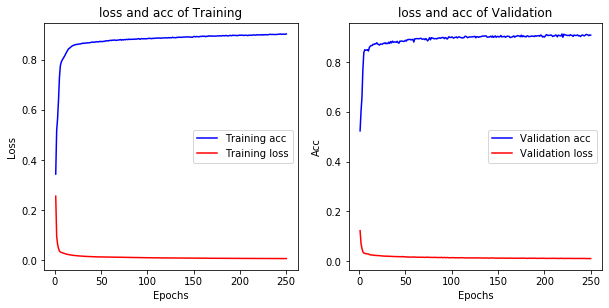

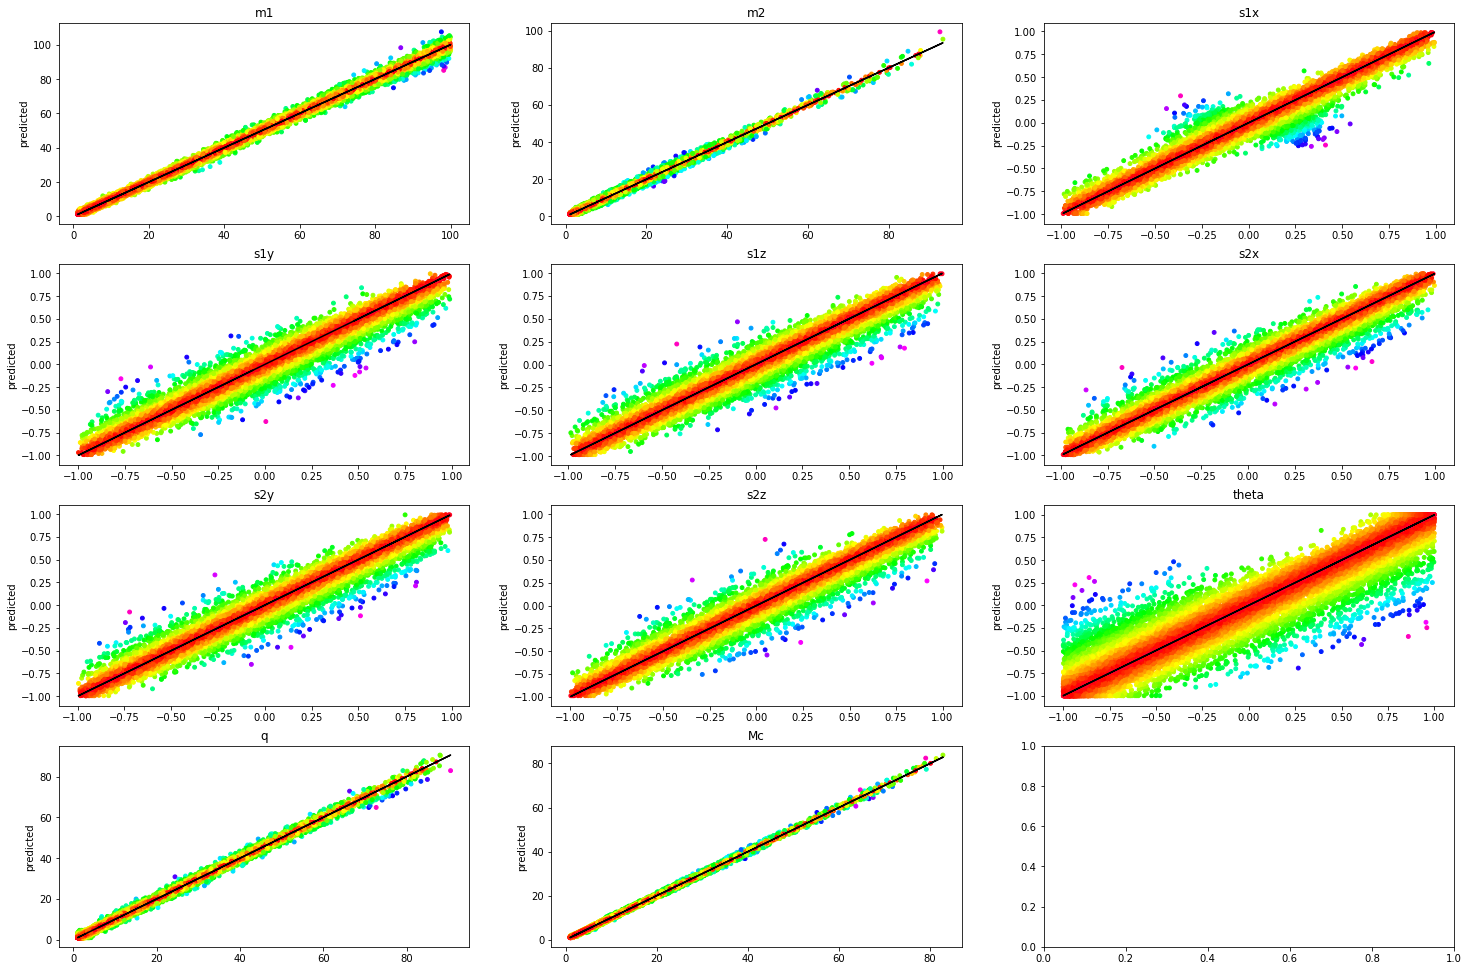

********************************************************************************
Key: v1c0
********************************************************************************
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 11)]         0           []                               
                                                                                                  
 dense_10 (Dense)               (None, 100)          1200        ['input_3[0][0]']                
                                                                                                  
 dense_11 (Dense)               (None, 100)          10100       ['dense_10[0][0]']               
                                                                                                  
 dense_12 (Dense)  

Epoch 69/250
282/282 [==============================] - 1s 2ms/step - loss: 0.0702 - mean_squared_error: 0.0702 - accuracy: 0.5403 - val_loss: 0.0699 - val_mean_squared_error: 0.0696 - val_accuracy: 0.5525
Epoch 70/250
282/282 [==============================] - 1s 2ms/step - loss: 0.0700 - mean_squared_error: 0.0700 - accuracy: 0.5397 - val_loss: 0.0697 - val_mean_squared_error: 0.0694 - val_accuracy: 0.5485
Epoch 71/250
282/282 [==============================] - 1s 2ms/step - loss: 0.0699 - mean_squared_error: 0.0699 - accuracy: 0.5406 - val_loss: 0.0687 - val_mean_squared_error: 0.0684 - val_accuracy: 0.5530
Epoch 72/250
282/282 [==============================] - 1s 2ms/step - loss: 0.0697 - mean_squared_error: 0.0698 - accuracy: 0.5417 - val_loss: 0.0696 - val_mean_squared_error: 0.0694 - val_accuracy: 0.5505
Epoch 73/250
282/282 [==============================] - 1s 2ms/step - loss: 0.0695 - mean_squared_error: 0.0696 - accuracy: 0.5449 - val_loss: 0.0691 - val_mean_squared_error: 

Epoch 109/250
282/282 [==============================] - 1s 2ms/step - loss: 0.0646 - mean_squared_error: 0.0645 - accuracy: 0.5649 - val_loss: 0.0641 - val_mean_squared_error: 0.0638 - val_accuracy: 0.5790
Epoch 110/250
282/282 [==============================] - 1s 2ms/step - loss: 0.0645 - mean_squared_error: 0.0645 - accuracy: 0.5666 - val_loss: 0.0641 - val_mean_squared_error: 0.0637 - val_accuracy: 0.5725
Epoch 111/250
282/282 [==============================] - 1s 2ms/step - loss: 0.0643 - mean_squared_error: 0.0643 - accuracy: 0.5649 - val_loss: 0.0646 - val_mean_squared_error: 0.0643 - val_accuracy: 0.5735
Epoch 112/250
282/282 [==============================] - 1s 2ms/step - loss: 0.0643 - mean_squared_error: 0.0642 - accuracy: 0.5652 - val_loss: 0.0641 - val_mean_squared_error: 0.0637 - val_accuracy: 0.5750
Epoch 113/250
282/282 [==============================] - 1s 2ms/step - loss: 0.0641 - mean_squared_error: 0.0642 - accuracy: 0.5684 - val_loss: 0.0635 - val_mean_squared_er

Epoch 188/250
282/282 [==============================] - 1s 2ms/step - loss: 0.0584 - mean_squared_error: 0.0584 - accuracy: 0.5924 - val_loss: 0.0590 - val_mean_squared_error: 0.0587 - val_accuracy: 0.5900
Epoch 189/250
282/282 [==============================] - 1s 2ms/step - loss: 0.0584 - mean_squared_error: 0.0584 - accuracy: 0.5897 - val_loss: 0.0588 - val_mean_squared_error: 0.0585 - val_accuracy: 0.5895
Epoch 190/250
282/282 [==============================] - 1s 2ms/step - loss: 0.0583 - mean_squared_error: 0.0583 - accuracy: 0.5884 - val_loss: 0.0588 - val_mean_squared_error: 0.0585 - val_accuracy: 0.5940
Epoch 191/250
282/282 [==============================] - 1s 2ms/step - loss: 0.0582 - mean_squared_error: 0.0582 - accuracy: 0.5923 - val_loss: 0.0585 - val_mean_squared_error: 0.0582 - val_accuracy: 0.5970
Epoch 192/250
282/282 [==============================] - 1s 2ms/step - loss: 0.0582 - mean_squared_error: 0.0582 - accuracy: 0.5912 - val_loss: 0.0591 - val_mean_squared_er

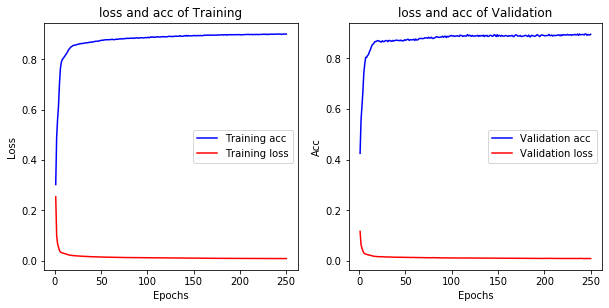

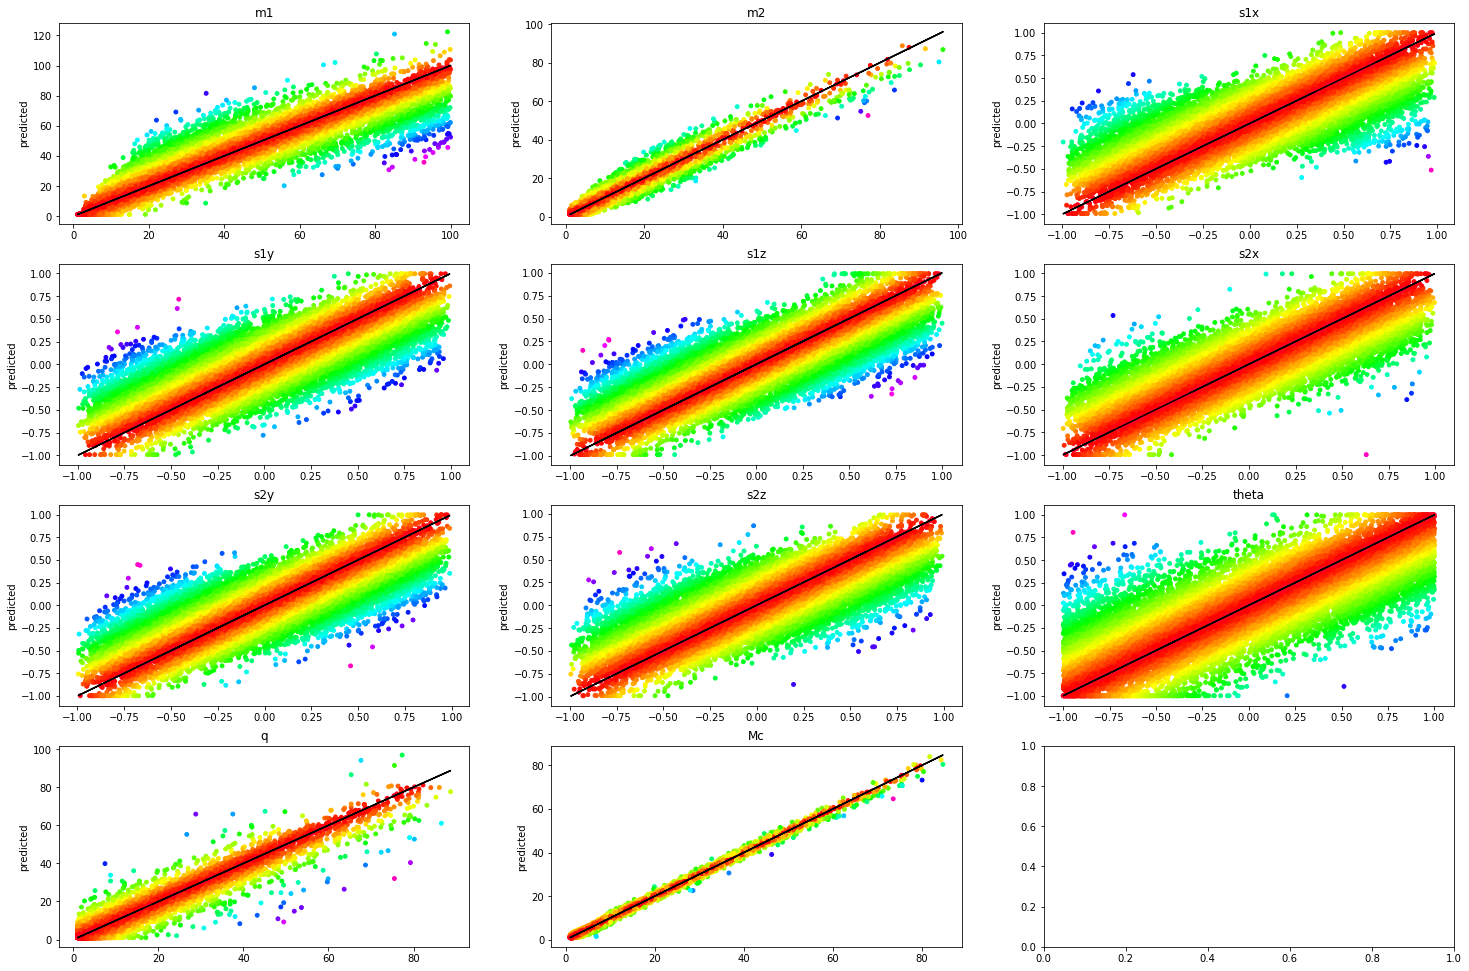

********************************************************************************
Key: v1c1
********************************************************************************
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 11)]         0           []                               
                                                                                                  
 dense_15 (Dense)               (None, 100)          1200        ['input_4[0][0]']                
                                                                                                  
 dense_16 (Dense)               (None, 100)          10100       ['dense_15[0][0]']               
                                                                                                  
 dense_17 (Dense)  

Epoch 69/250
282/282 [==============================] - 1s 2ms/step - loss: 0.0671 - mean_squared_error: 0.0671 - accuracy: 0.5532 - val_loss: 0.0525 - val_mean_squared_error: 0.0526 - val_accuracy: 0.5885
Epoch 70/250
282/282 [==============================] - 1s 2ms/step - loss: 0.0669 - mean_squared_error: 0.0668 - accuracy: 0.5545 - val_loss: 0.0525 - val_mean_squared_error: 0.0526 - val_accuracy: 0.5850
Epoch 71/250
282/282 [==============================] - 1s 2ms/step - loss: 0.0667 - mean_squared_error: 0.0667 - accuracy: 0.5548 - val_loss: 0.0524 - val_mean_squared_error: 0.0525 - val_accuracy: 0.5950
Epoch 72/250
282/282 [==============================] - 1s 2ms/step - loss: 0.0666 - mean_squared_error: 0.0665 - accuracy: 0.5548 - val_loss: 0.0528 - val_mean_squared_error: 0.0529 - val_accuracy: 0.5935
Epoch 73/250
282/282 [==============================] - 1s 2ms/step - loss: 0.0664 - mean_squared_error: 0.0663 - accuracy: 0.5552 - val_loss: 0.0528 - val_mean_squared_error: 

Epoch 109/250
282/282 [==============================] - 1s 2ms/step - loss: 0.0615 - mean_squared_error: 0.0615 - accuracy: 0.5767 - val_loss: 0.0482 - val_mean_squared_error: 0.0483 - val_accuracy: 0.6185
Epoch 110/250
282/282 [==============================] - 1s 2ms/step - loss: 0.0613 - mean_squared_error: 0.0613 - accuracy: 0.5782 - val_loss: 0.0483 - val_mean_squared_error: 0.0484 - val_accuracy: 0.6105
Epoch 111/250
282/282 [==============================] - 1s 2ms/step - loss: 0.0613 - mean_squared_error: 0.0612 - accuracy: 0.5765 - val_loss: 0.0484 - val_mean_squared_error: 0.0485 - val_accuracy: 0.6165
Epoch 112/250
282/282 [==============================] - 1s 2ms/step - loss: 0.0612 - mean_squared_error: 0.0611 - accuracy: 0.5799 - val_loss: 0.0479 - val_mean_squared_error: 0.0481 - val_accuracy: 0.6135
Epoch 113/250
282/282 [==============================] - 1s 2ms/step - loss: 0.0611 - mean_squared_error: 0.0611 - accuracy: 0.5802 - val_loss: 0.0476 - val_mean_squared_er

Epoch 188/250
282/282 [==============================] - 1s 2ms/step - loss: 0.0551 - mean_squared_error: 0.0551 - accuracy: 0.6094 - val_loss: 0.0429 - val_mean_squared_error: 0.0431 - val_accuracy: 0.6555
Epoch 189/250
282/282 [==============================] - 1s 3ms/step - loss: 0.0550 - mean_squared_error: 0.0550 - accuracy: 0.6092 - val_loss: 0.0432 - val_mean_squared_error: 0.0433 - val_accuracy: 0.6520
Epoch 190/250
282/282 [==============================] - 1s 2ms/step - loss: 0.0550 - mean_squared_error: 0.0550 - accuracy: 0.6086 - val_loss: 0.0423 - val_mean_squared_error: 0.0424 - val_accuracy: 0.6545
Epoch 191/250
282/282 [==============================] - 1s 2ms/step - loss: 0.0549 - mean_squared_error: 0.0549 - accuracy: 0.6106 - val_loss: 0.0428 - val_mean_squared_error: 0.0429 - val_accuracy: 0.6590
Epoch 192/250
282/282 [==============================] - 1s 2ms/step - loss: 0.0549 - mean_squared_error: 0.0549 - accuracy: 0.6098 - val_loss: 0.0424 - val_mean_squared_er

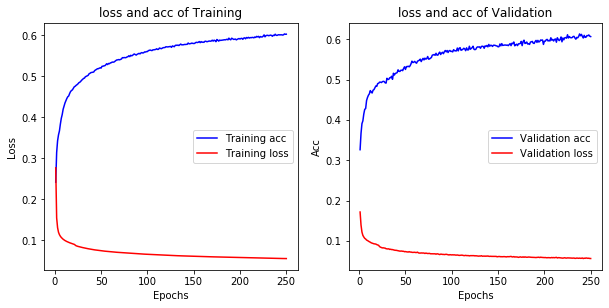

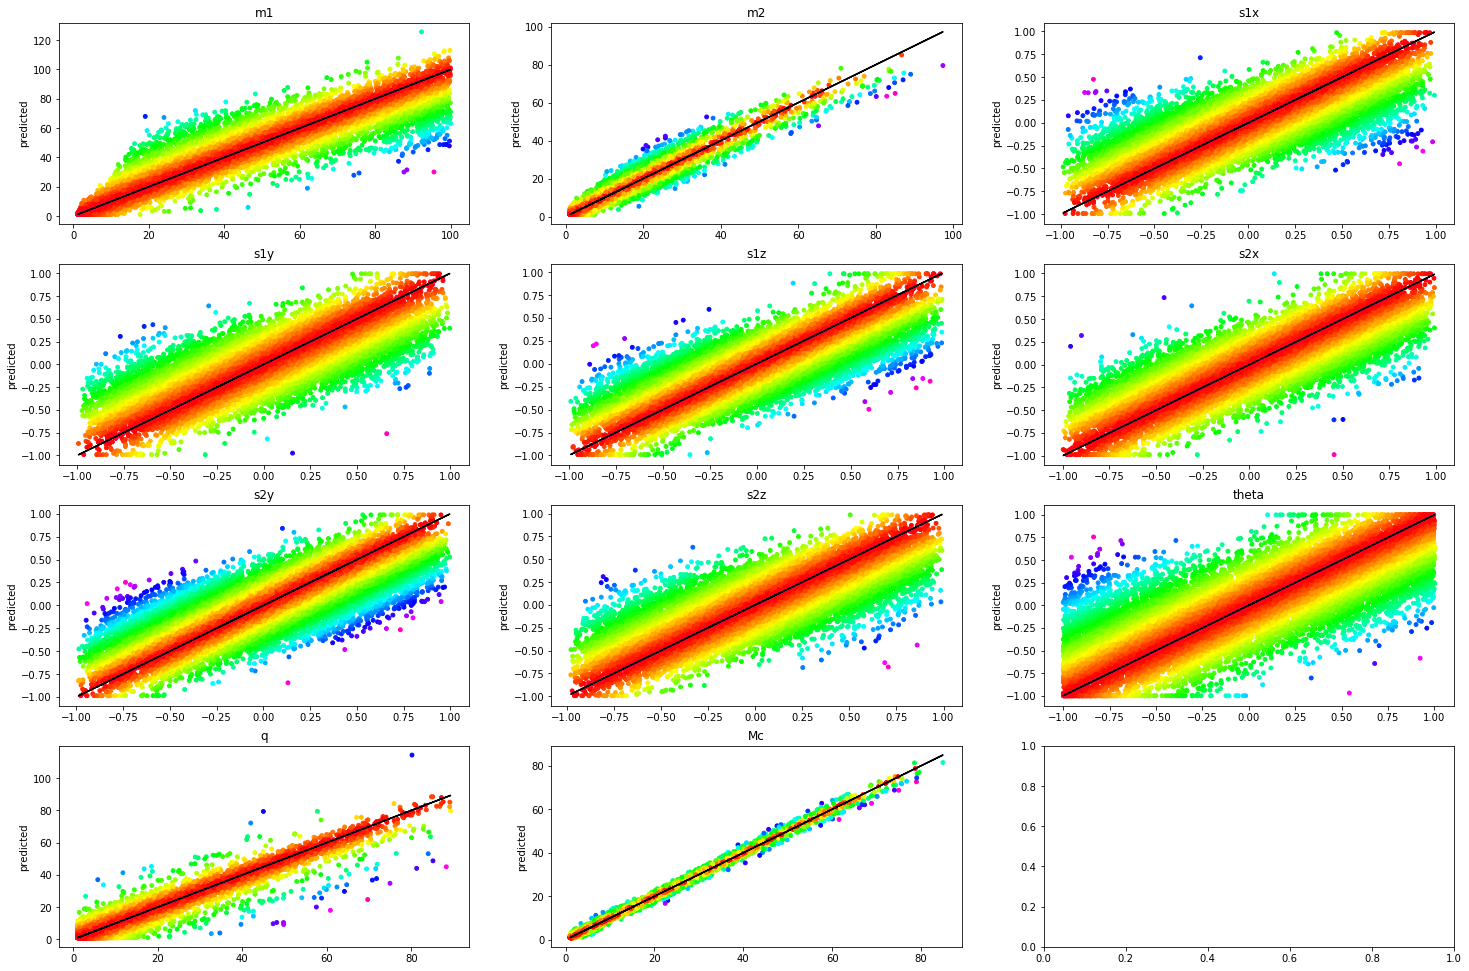

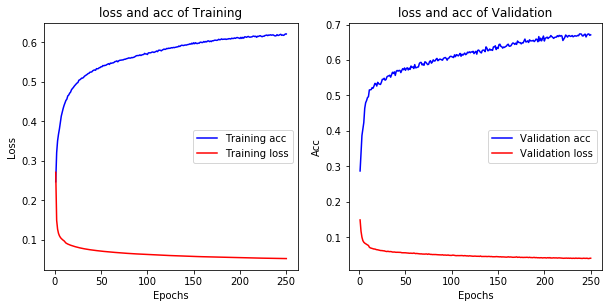

In [6]:
dashes = '*'*80

for key in keys:
    print(dashes, '\nKey: ', key, '\n', dashes, sep='')
    
    data_paths = {}
    data_paths['xtrain'] = regr_data_dir+key+'train_x.csv'
    data_paths['ytrain'] = regr_data_dir+key+'train_y.csv'
    data_paths['xtest']  = regr_data_dir+key+'test_x.csv'
    data_paths['ytest']  = regr_data_dir+key+'test_y.csv'

    rdl_out = ut.regressionDatasetLoader(data_paths, features_names,
                           scaler_type=scaler_type,
                           remove_some_mass=remove_some_mass)
    
    xtrain   = rdl_out['xtrain']
    ytrain   = rdl_out['ytrain']
    xtest    = rdl_out['xtest']
    ytest    = rdl_out['ytest']
    scaler_x = rdl_out['scaler_x']
    scaler_y = rdl_out['scaler_y']
    labels   = rdl_out['labels']
    
    Nfeatures = len(xtrain[0,:])
    
    # build, compile and train the model
    model = buildModelUsingFunctionalAPI(hlayers_sizes, batch_size, Nfeatures, out_activation=out_activation)
    model.compile(
        loss=mse, 
        optimizer=Adam(learning_rate=learning_rate), 
        metrics=[mse, 'accuracy']
    )
    model.summary()
    t0 = time.perf_counter()
    history = model.fit(xtrain, ytrain, 
        epochs           = epochs, 
        batch_size       = batch_size,
        validation_split = validation_split,
        verbose          = verbose_training
    )
    train_time = time.perf_counter()-t0
    
    # predict
    ypredicted = model.predict(xtest)
    
    # print some information
    metrics_dict = ut.evalutationMetricsDict(xtest,ytest,model)
    ut.printMetrics(metrics_dict)

    # update dictionary adding data (both normalized and not), model and score
    datasets[key].train_time = train_time
    datasets[key].model      = model
    datasets[key].history    = history
    datasets[key].predicted  = scaler_y.inverse_transform(ypredicted)
    datasets[key].metrics    = metrics_dict
    datasets[key].Ntrain     = len(xtrain[:,0])
    
    # plot
    ut.predictionPlots(ytest, ypredicted, labels, scaler=scaler_y)
    
    del model
    
    ut.plotHistory(history)

## Produce CSV files

In [7]:
if write_output:
    for key in keys:
        # save csv
        filename = out_data_dir+'NN_tf_'+key+'.csv'
        ut.writeResult(filename, datasets[key].predicted, verbose=True)
        
        # save model
        #dict_name = out_data_dir+'NN_tf_'+key+'.dict'
        #pickle.dump(datasets[key].model, open(dict_name, 'wb'))
        #print(dict_name, 'saved') 
        
        # example for loading models
        #dict_name    = out_data_dir+'NN_tf_'+key+'.dict'
        #print('Loading', dict_name, '...')
        #loaded_model = pickle.load(open(dict_name, 'rb'))

../NN_tf_results/NN_tf_v0c0.csv saved
../NN_tf_results/NN_tf_v0c1.csv saved
../NN_tf_results/NN_tf_v1c0.csv saved
../NN_tf_results/NN_tf_v1c1.csv saved
